# Point matching for automatic fiducial registration

This is an important problem for doing thick PALM where we take data in slabs but each slab has to be individually drift corrected. We have an overall scaffold to which we need to align the data.

Ideally we'd generate a program that would do the following steps
1. Read in the data (or generate it ...)
    1. Read in slab data
    2. Read in scaffold data
2. Automatically find fiducials
    1. Do drift correction if it hasn't been done already
    2. localize fiducials in the scaffold
3. **Using the fiducials automatically align the slabs to the scaffold.**

The last point is the issue for this notebook. We'll be primarily working off the methods mentioned [here](https://en.wikipedia.org/wiki/Point_set_registration).

The main methods are:
1. [Iterative closest point](https://en.wikipedia.org/wiki/Iterative_closest_point)
    - http://connor-johnson.com/2014/06/06/an-iterative-closest-point-algorithm/
    - https://stackoverflow.com/questions/20120384/iterative-closest-point-icp-implementation-on-python
    - https://engineering.purdue.edu/kak/distICP/ICP-2.0.html
    - https://github.com/ClayFlannigan/icp
2. Robust point matching
    - http://scikit-image.org/docs/dev/auto_examples/transform/plot_matching.html
3. Kernel Correlation
4. Coherent Point Drift
    - https://github.com/Hennrik/Coherent-Point-Drift-Python
    - https://github.com/siavashk/pycpd

![](https://upload.wikimedia.org/wikipedia/commons/f/fe/Cpd_fish_affine.gif)

# Basics

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Testing out the `pycpd` package

https://github.com/siavashk/pycpd (no idea if this is implemented correctly)

http://siavashk.github.io/2017/05/14/coherent-point-drift/ blog post explaining the math

Original paper: https://arxiv.org/pdf/0905.2635.pdf

**Note:** if the code follows the notation of the paper then $w$ is the weight of the uniform distribution that's included in the gaussian mixture model to model noise. We need to test a good default value for this parameter but 0.5 seems good from initial experiments (2D)

One thing they mention in the paper:
>We shall always prealign both point sets to zero mean and unit variance before the registration.

## Starting out with the fishy

In [2]:
from pycpd import affine_registration, deformable_registration, rigid_registration
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# need to add translation only registration
class translation_registration(object):
    def __init__(self, X, Y, t=None, sigma2=None, maxIterations=100, tolerance=0.001, w=0):
        if X.shape[1] != Y.shape[1]:
            raise 'Both point clouds must have the same number of dimensions!'

        self.X             = X
        self.Y             = Y
        self.TY            = Y
        (self.N, self.D)   = self.X.shape
        (self.M, _)        = self.Y.shape
        self.t             = np.atleast_2d(np.zeros((1, self.D))) if t is None else t
        self.sigma2        = sigma2
        self.iteration     = 0
        self.maxIterations = maxIterations
        self.tolerance     = tolerance
        self.w             = w
        self.q             = 0
        self.err           = 0

    def register(self, callback):
        self.initialize()

        while self.iteration < self.maxIterations and self.err > self.tolerance:
            self.iterate()
            if callback:
                callback(iteration=self.iteration, error=self.err, X=self.X, Y=self.TY)

        return self.TY, np.atleast_2d(self.t), self.P

    def iterate(self):
        self.EStep()
        self.MStep()
        self.iteration += 1

    def MStep(self):
        self.updateTransform()
        self.transformPointCloud()
        self.updateVariance()

    def updateTransform(self):
        muX = np.divide(np.sum(np.dot(self.P, self.X), axis=0), self.Np)
        muY = np.divide(np.sum(np.dot(np.transpose(self.P), self.Y), axis=0), self.Np)

        self.XX = self.X - np.tile(muX, (self.N, 1))
        YY      = self.Y - np.tile(muY, (self.M, 1))

        self.A = np.dot(np.transpose(self.XX), np.transpose(self.P))
        self.A = np.dot(self.A, YY)

        self.YPY = np.dot(np.transpose(self.P1), np.sum(np.multiply(YY, YY), axis=1))

        self.t = np.transpose(muX) - np.transpose(muY)

    def transformPointCloud(self, Y=None):
        if Y is None:
            self.TY = self.Y + np.tile(np.transpose(self.t), (self.M, 1))
            return
        else:
            return Y + np.tile(np.transpose(self.t), (Y.shape[0], 1))

    def updateVariance(self):
        # needs work
        qprev = self.q

        trAR     = np.trace(self.A)
        xPx      = np.dot(np.transpose(self.Pt1), np.sum(np.multiply(self.XX, self.XX), axis =1))
        self.q   = (xPx - 2 * trAR + self.YPY) / (2 * self.sigma2) + self.D * self.Np/2 * np.log(self.sigma2)
        self.err = np.abs(self.q - qprev)

        self.sigma2 = (xPx - trAR) / (self.Np * self.D)

        if self.sigma2 <= 0:
            self.sigma2 = self.sigma_init = self.sigma_init * 2.0
            self.t = -self.Y.mean(axis=0) + self.X.mean(axis=0)
            #+np.random.randn(*self.t.shape) * np.sqrt(self.Y.var(axis=0) * self.sigma2 + self.X.mean(axis=0))
            #self.t = np.zeros_like(self.t)
            self.transformPointCloud()
    
    def initialize(self):
        self.TY = self.Y + np.repeat(self.t, self.M, axis=0)
        if not self.sigma2:
            XX = np.reshape(self.X, (1, self.N, self.D))
            YY = np.reshape(self.TY, (self.M, 1, self.D))
            XX = np.tile(XX, (self.M, 1, 1))
            YY = np.tile(YY, (1, self.N, 1))
            diff = XX - YY
            err  = np.multiply(diff, diff)
            self.sigma2 = np.sum(err) / (self.D * self.M * self.N)
            
        self.sigma_init = self.sigma2

        self.err  = self.tolerance + 1
        self.q    = -self.err - self.N * self.D/2 * np.log(self.sigma2)

    def EStep(self):
        P = np.zeros((self.M, self.N))

        for i in range(0, self.M):
            diff     = self.X - np.tile(self.TY[i, :], (self.N, 1))
            diff    = np.multiply(diff, diff)
            P[i, :] = P[i, :] + np.sum(diff, axis=1)

        c = (2 * np.pi * self.sigma2) ** (self.D / 2)
        c = c * self.w / (1 - self.w)
        c = c * self.M / self.N
        
        P = np.exp((-P / (2 * self.sigma2)))
        den = np.sum(P, axis=0)
        den = np.tile(den, (self.M, 1))
        den = np.maximum(np.finfo(float).eps, den)
        den += c

        self.P   = np.divide(P, den)
        self.Pt1 = np.sum(self.P, axis=0)
        self.P1  = np.sum(self.P, axis=1)
        self.Np  = max(np.finfo(float).eps, np.sum(self.P1))

Max iterations reached, error = 5.37204929287e-05
100


<IPython.core.display.Javascript object>


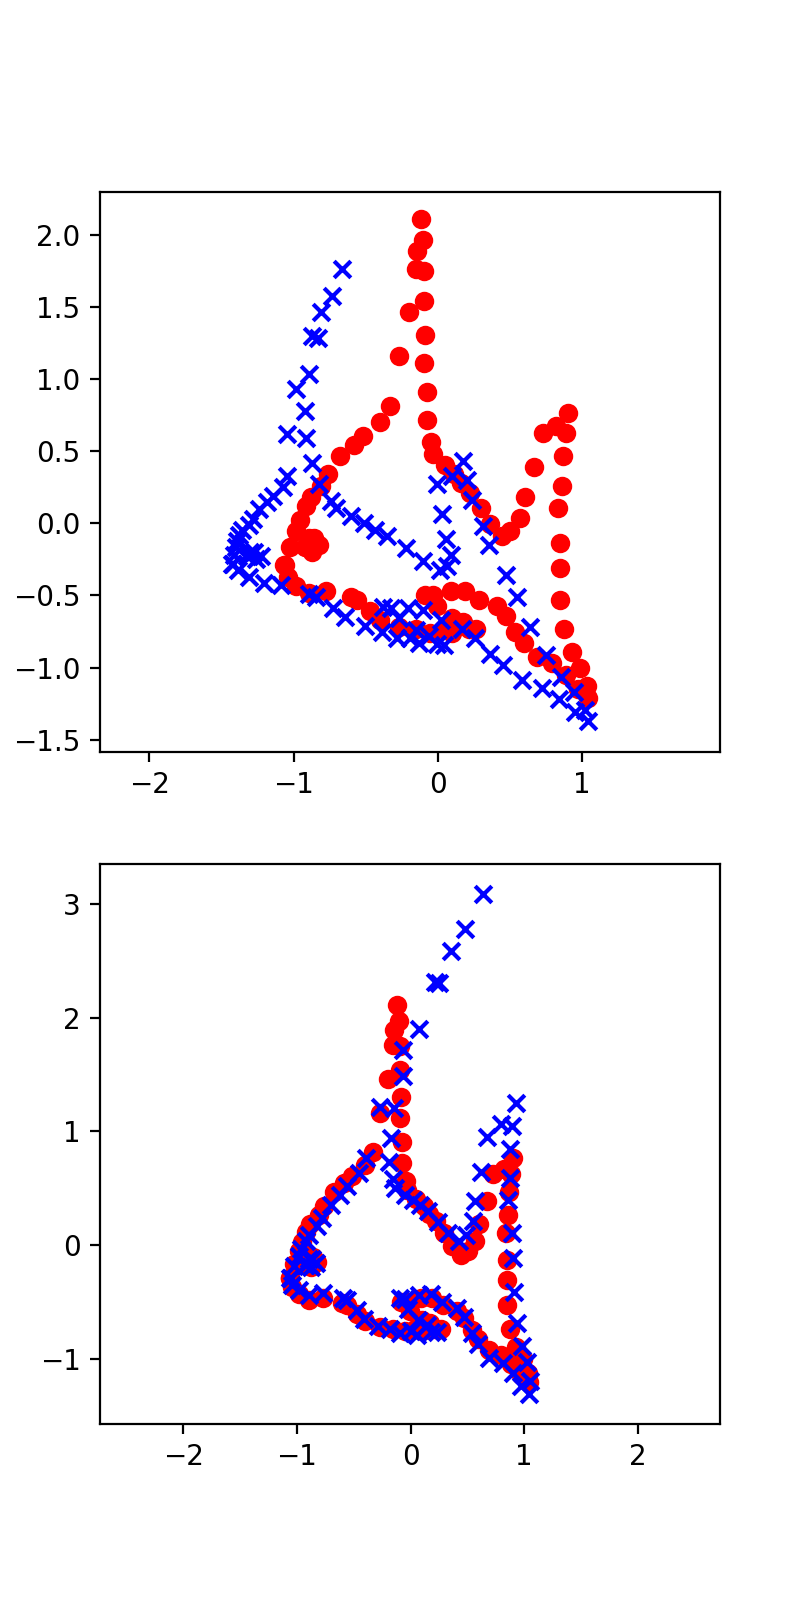

In [4]:
def main(X, Y, model=affine_registration, **kwargs):
    
    default_kwargs = dict(maxIterations=100, tolerance=1e-5, w=0.5)
    default_kwargs.update(kwargs)

    reg = model(X.T, Y.T, **default_kwargs)
    result = reg.register(None)
    if not reg.iteration < reg.maxIterations:
        print("Max iterations reached, error =", reg.err)
    print(reg.iteration)
    
    if len(X) == 3:
        projection = "3d"
    else:
        projection = None
    fig = plt.figure(figsize=(4,8))
    ax0 = fig.add_subplot(211, projection=projection)
    ax1 = fig.add_subplot(212, projection=projection)
    
    ax0.scatter(*X, color='red')
    ax0.scatter(*Y, color='blue', marker="x")
    
    ax1.scatter(*X, color='red')
    ax1.scatter(*result[0].T, color='blue', marker="x")
    ax0.set_aspect('equal', 'datalim')
    ax1.set_aspect('equal', 'datalim')
    
    return (result[0].T, )+ result[1:]
    
    

fish = np.load('fish.npz')
X = fish['X']
Y = fish['Y']
r = main(X, Y)

In [5]:
def rmse(x, y):
    return np.sqrt(((x - y)**2).sum(0)).mean()

727


<IPython.core.display.Javascript object>


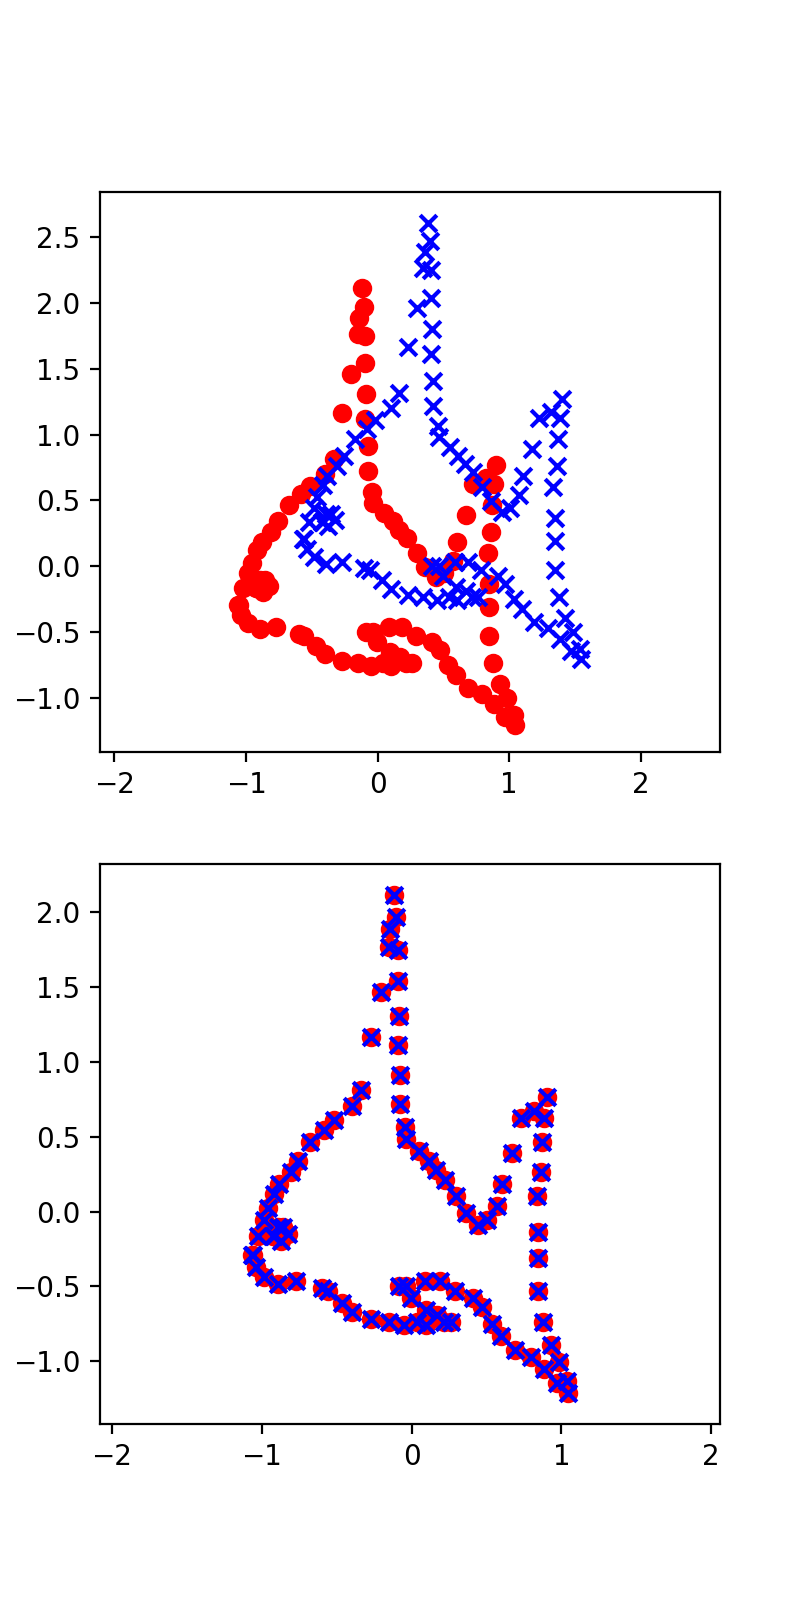

1.3208413471333871e-16

In [6]:
fish = np.load('fish.npz')
X = fish['X']
Y = fish['X'] + np.array((0.5, 0.5))[:, None]
r = main(X, Y, translation_registration, maxIterations=1000, tolerance=0.001)
rmse(X, r[0])

42


<IPython.core.display.Javascript object>


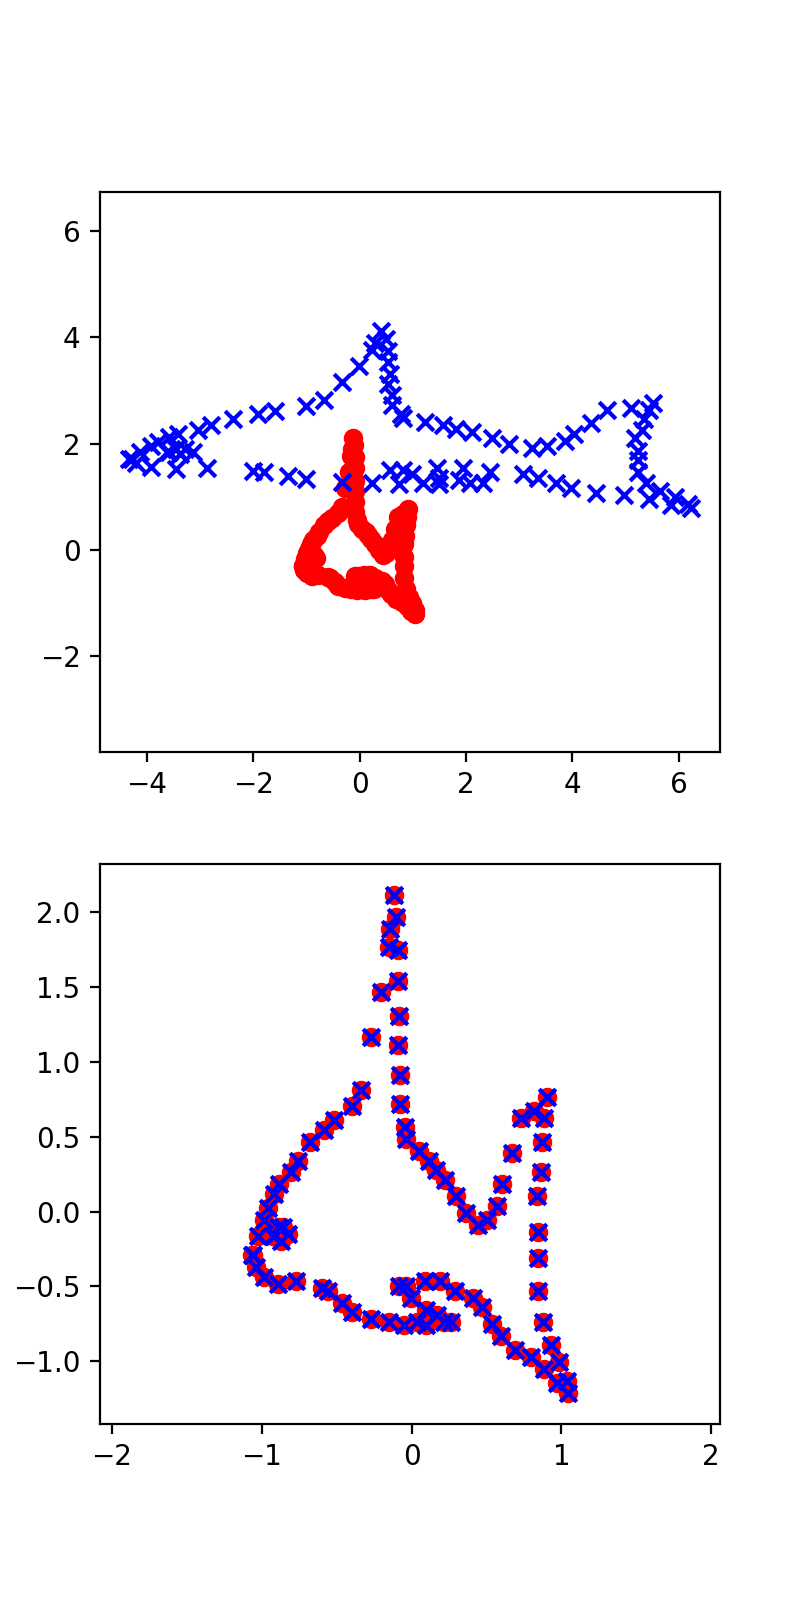

6.6241696124108901e-16

In [7]:
fish = np.load('fish.npz')
X = fish['X']
Y = fish['X'] * np.array((5, 1))[:, None] + np.array((1, 2))[:, None]
r = main(X, Y)
rmse(X, r[0])

## Testing on a toy model for fiducials

In [8]:
trans = np.random.rand(2, 1) * 2
print(trans)

ps1 = np.random.rand(2, 100)
ps2 = ps1 + trans

[[ 0.88600473]
 [ 0.08836961]]


33


<IPython.core.display.Javascript object>


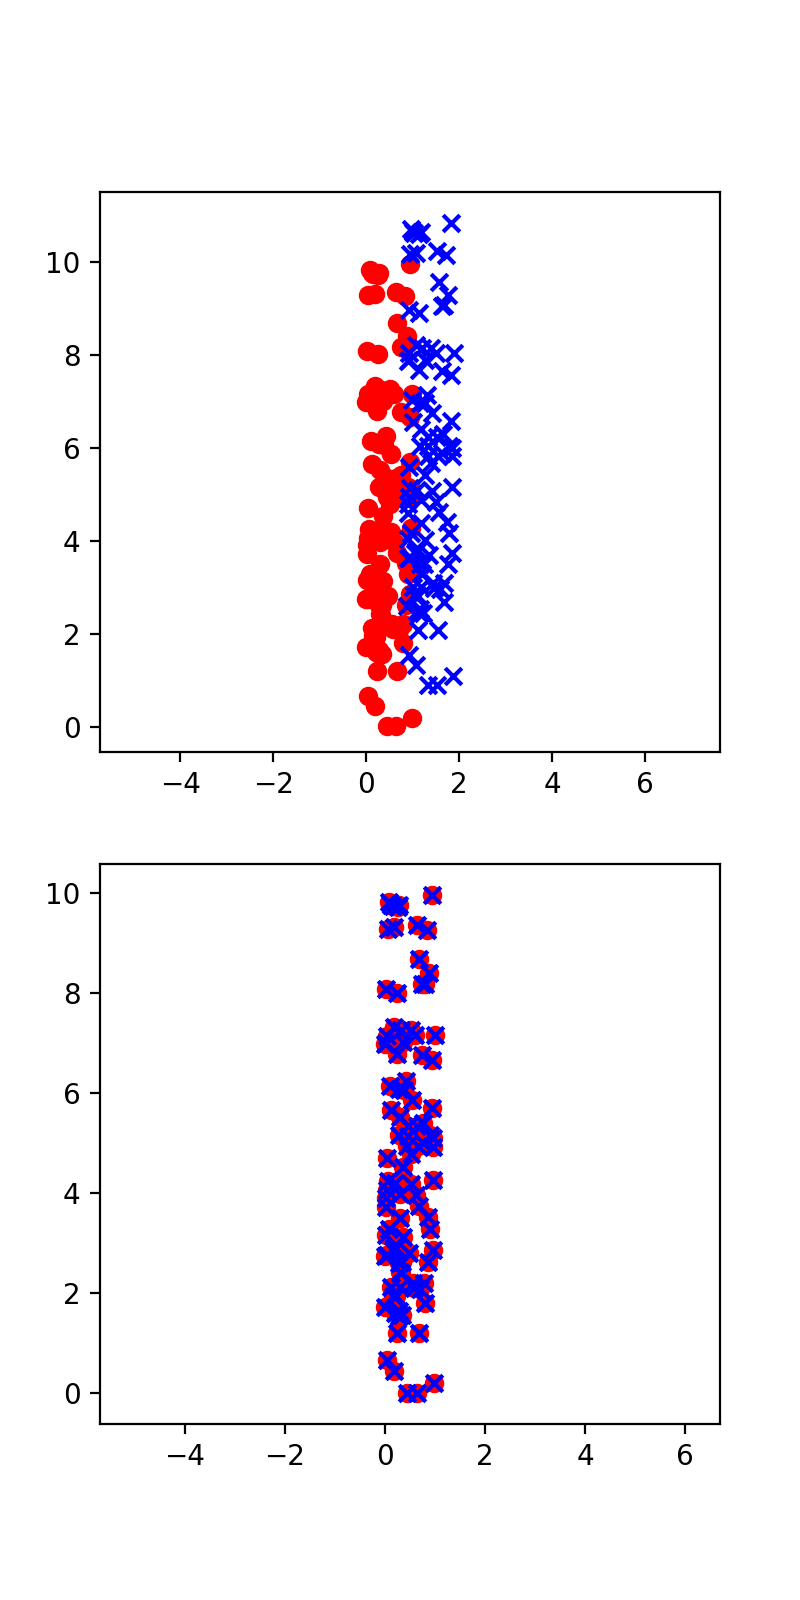

4.2611653754053753

In [9]:
s = np.array((1,10))[:, None]
r = main(ps1*s, ps2*s, translation_registration, w=0)
rmse(ps1, r[0])

### Apect ratio

Looks like if the data points are way off in aspect ratio than the algorithm can fail. This should be pretty easily fixed by prescaling the points so that they have equal extent in each direction and then undoing the scaling after registration.

In [10]:
def AffineTransform(rotation=0, translation=(0,0)):
    R = np.array(((np.cos(rotation), -np.sin(rotation)), (np.sin(rotation), np.cos(rotation))))
    t = np.array(translation)[:, None]
    return R, t

Max iterations reached, error = 533.817709191
100


<IPython.core.display.Javascript object>


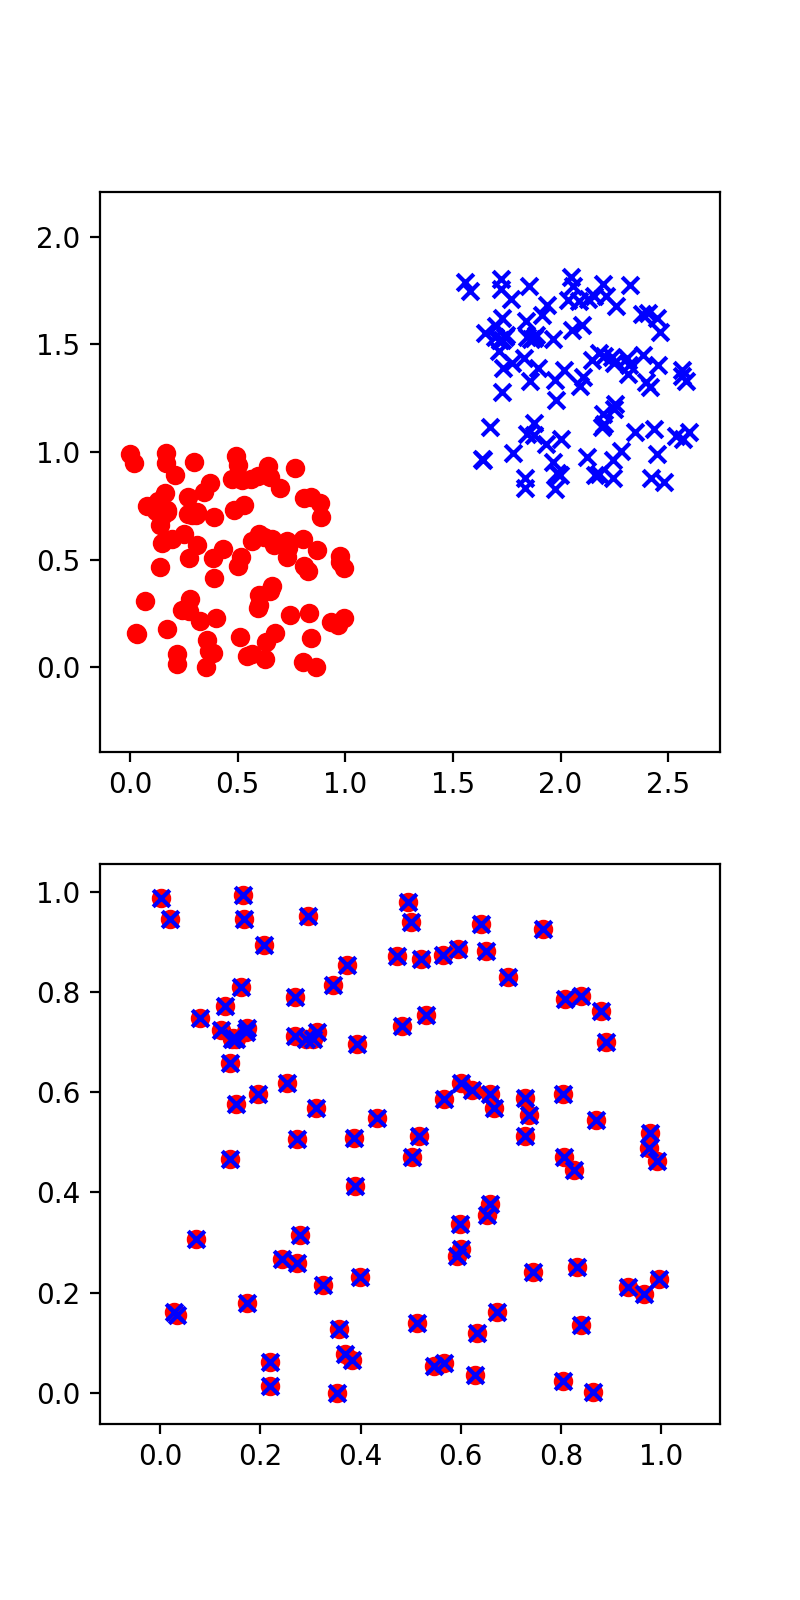

1.3514920192470804e-15

In [11]:
R, t = AffineTransform(rotation=np.random.rand() * np.pi * 0.2,
                        translation=np.random.rand(2) * 2)

ps1 = np.random.rand(2, 100)
ps2 = R @ ps1 + t

r = main(ps1, ps2, rigid_registration)
rmse(ps1, r[0])

Things will fail if the two point clouds are far off, in terms of rotation (for our data we don't have to worry about rotation at all really, mostly just translation, and not much of it.

Next we need to look at noise ...

### Noise time

[[ 0.88600473]
 [ 0.08836961]]
65


<IPython.core.display.Javascript object>


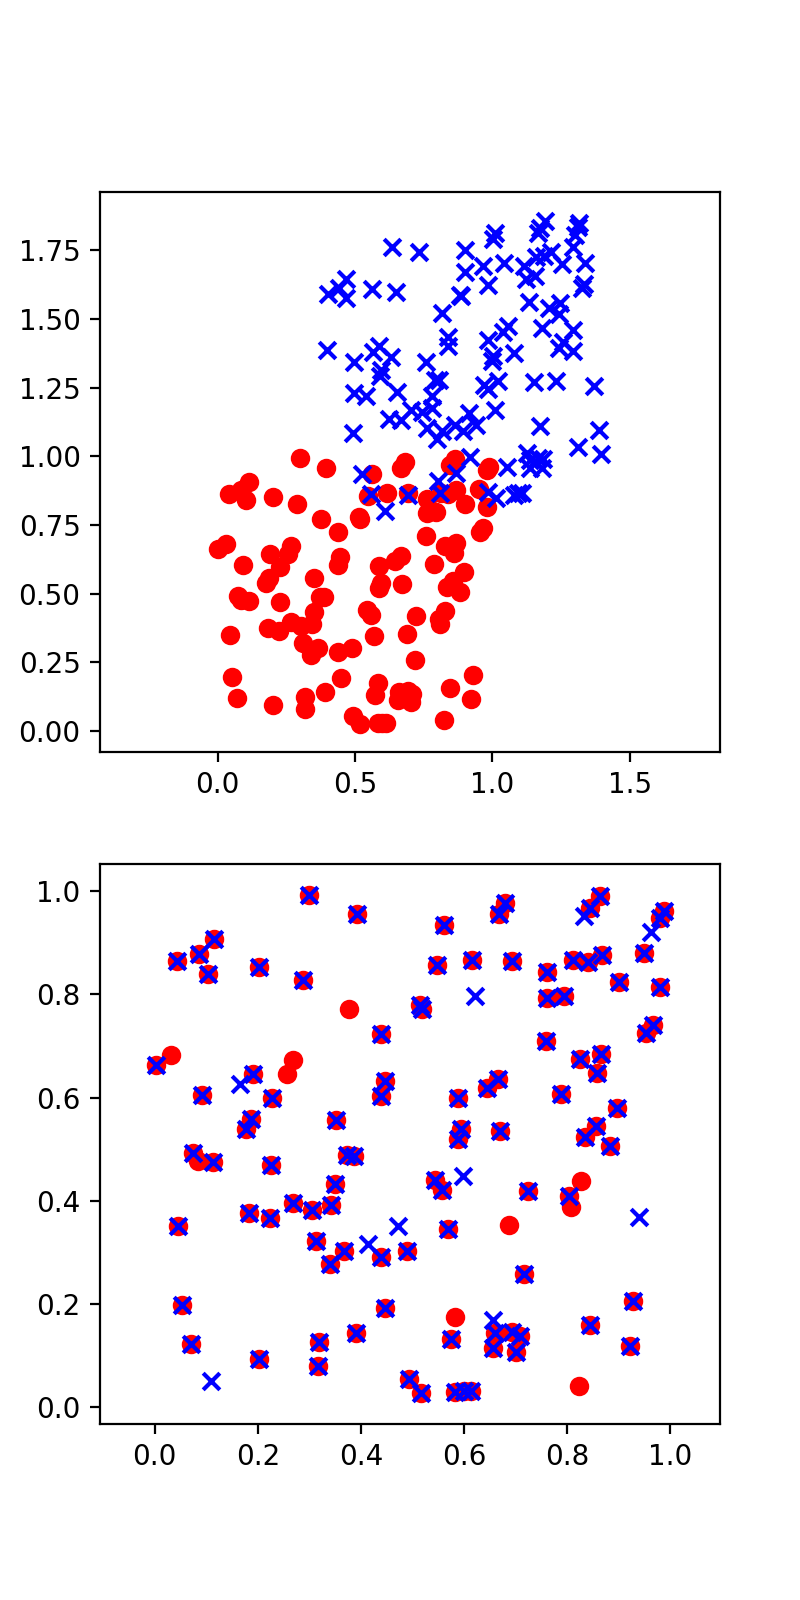

0.03988032981052702

In [12]:
R, t = AffineTransform(rotation=np.random.rand() * np.pi * 0.1,
                        translation=np.random.rand(2) * 1)
print(trans)

npnts = 100
noise = 10
npnts1, npnts2 = np.random.rand(2, 2, noise)#np.random.randint(noise))

realpnts = np.random.rand(2, npnts)
ps1 = np.concatenate((realpnts, npnts1), axis=1)
ps2 = R @ np.concatenate((realpnts, npnts2), axis=1) + t

r = main(ps1, ps2, model=rigid_registration, w=0.5)
rmse(ps1[:npnts], r[0][:npnts])

## Time for 3D!

In [13]:
npnts = 25
noise = 25
npnts1, npnts2 = np.random.rand(2, 3, np.random.randint(noise))

realpnts = np.random.rand(3, npnts)
ps1 = np.concatenate((realpnts, npnts1), axis=1)
ps2 = np.concatenate((realpnts, npnts2), axis=1) + np.random.randn(3, 1)

Max iterations reached, error = 0.521442004024
100


<IPython.core.display.Javascript object>


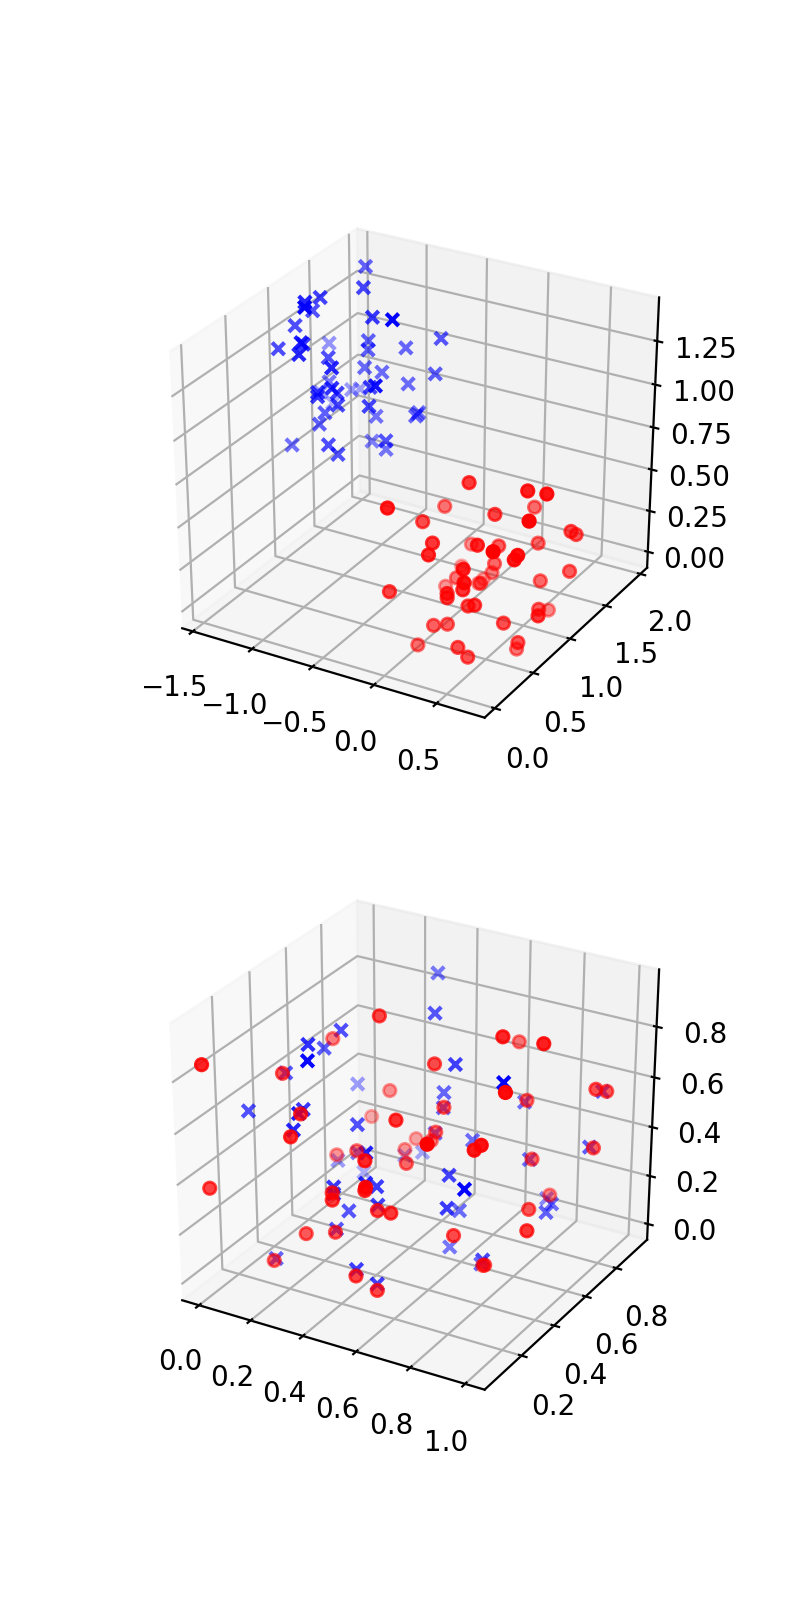

0.36927582908267292

In [14]:
r = main(ps1, ps2, model=rigid_registration)
rmse(ps1[:npnts], r[0][:npnts])

# Real deal

Here's the plan:
1. Make a 3d set of points
1. Split the set into slabs
1. add noise to scaffold and slabs (after first round)
1. add random translation to slabs


1. Try aligning slabs to scaffold straight
1. try prepositioning slabs using known offset

In [15]:
npnts = 50
nnoise = 0
nslabs = 2
noise_pnts1, noise_pnts2 = np.random.rand(2, 3, nnoise)

realpnts = np.random.rand(3, npnts)
ps1 = np.concatenate((realpnts, npnts1), axis=1)
ps2 = np.concatenate((realpnts, npnts2), axis=1)

scale = np.array((0.5, 10, 10))[:, None]
ps1 = ps1 * scale
ps2 = ps2 * scale

slab_limits = np.linspace(0, scale[0], nslabs + 1)
# These are aligned slabs
slabs = [ps2[:, (slab_limits[i] < ps2[0]) & (ps2[0] < slab_limits[i + 1])] for i in range(nslabs)]
slabs_wnoise = [slab + np.random.randn(3, 1) * scale * 0.1 for slab in slabs]

In [16]:
def main2(X, slabs, model=translation_registration, **kwargs):
    
    default_kwargs = dict(maxIterations=100, tolerance=1e-5, w=0.5)
    default_kwargs.update(kwargs)
    
    results = []
    for Y in slabs:
        reg = model(X.T, Y.T, **default_kwargs)
        result = reg.register(None)
        if not reg.iteration < reg.maxIterations:
            print("Error =", reg.err, "Max iterations reached, ", end="")
        print("iterations =", reg.iteration)
        print(result[-2])
        results.append((result[0].T, )+ result[1:])
    
    if len(X) == 3:
        projection = "3d"
    else:
        projection = None
    fig = plt.figure(figsize=(4,8))
    ax0 = fig.add_subplot(211, projection=projection)
    ax1 = fig.add_subplot(212, projection=projection)
    
    ax0.scatter(*X, color='k')
    ax1.scatter(*X, color='k')
    for ax in (ax0, ax1):
        ax.set_prop_cycle(plt.cycler('color', ['c', 'm', 'y', 'r', 'g', 'b']))
    for Y, result in zip(slabs, results):
        ax0.scatter(*Y, marker="x")
        ax1.scatter(*result[0], marker="x")
#     ax0.set_aspect('equal', 'datalim')
#     ax1.set_aspect('equal', 'datalim')
    
    return results

iterations = 51
[[ 0.07018465  0.90909745 -1.50112048]]
iterations = 331
[[-0.05550052  1.68606437 -0.83797935]]


<IPython.core.display.Javascript object>


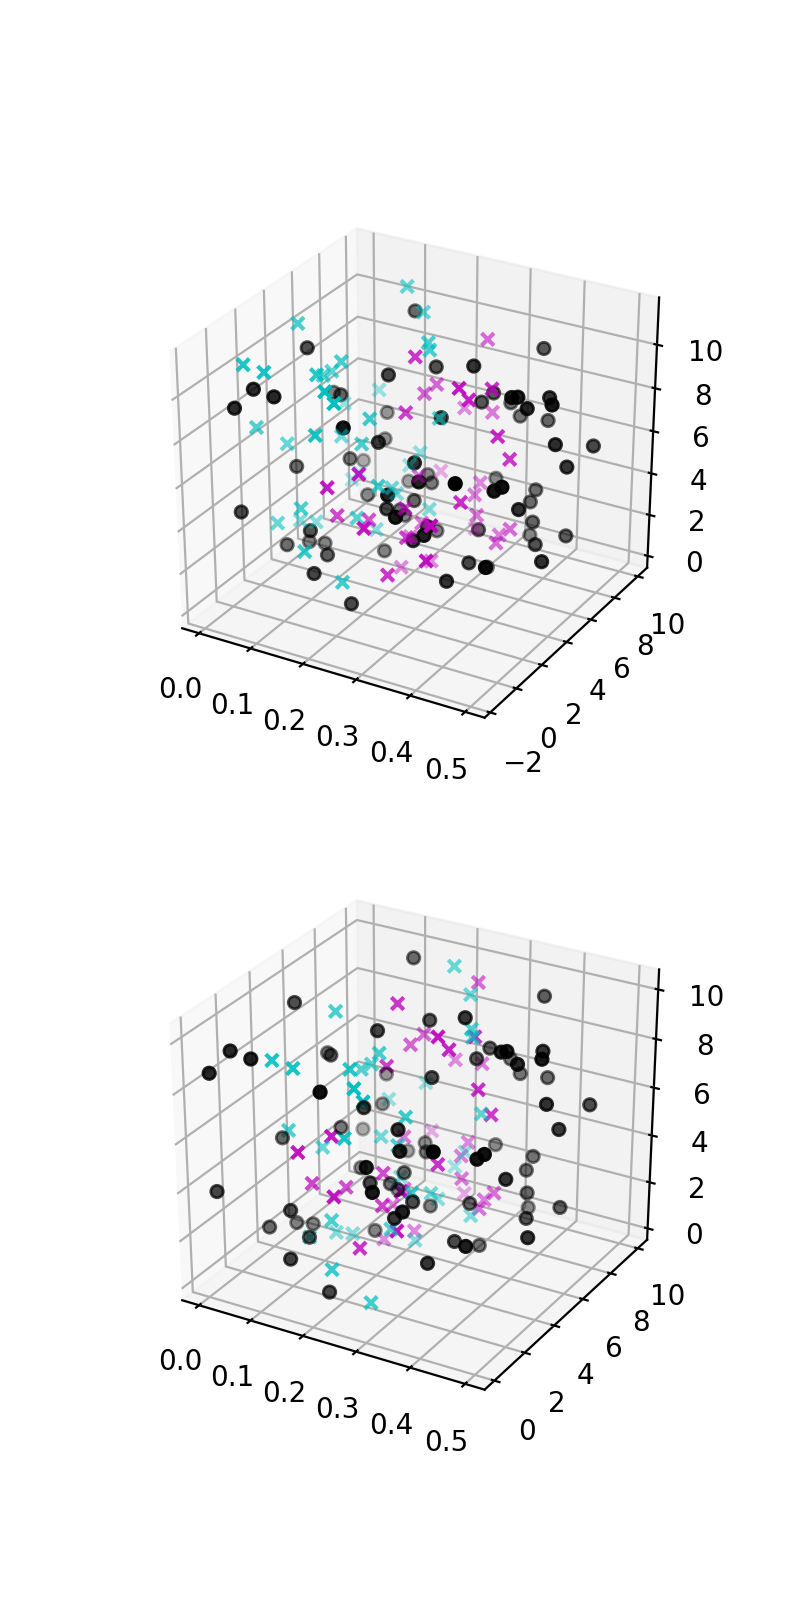

In [17]:
with np.errstate(invalid="raise"):
    r = main2(ps1, slabs_wnoise, translation_registration, w=1 - 1 / nslabs, maxIterations=1000, tolerance=1e-8)
# rmse(ps1[:npnts], r[0][:npnts])

<IPython.core.display.Javascript object>


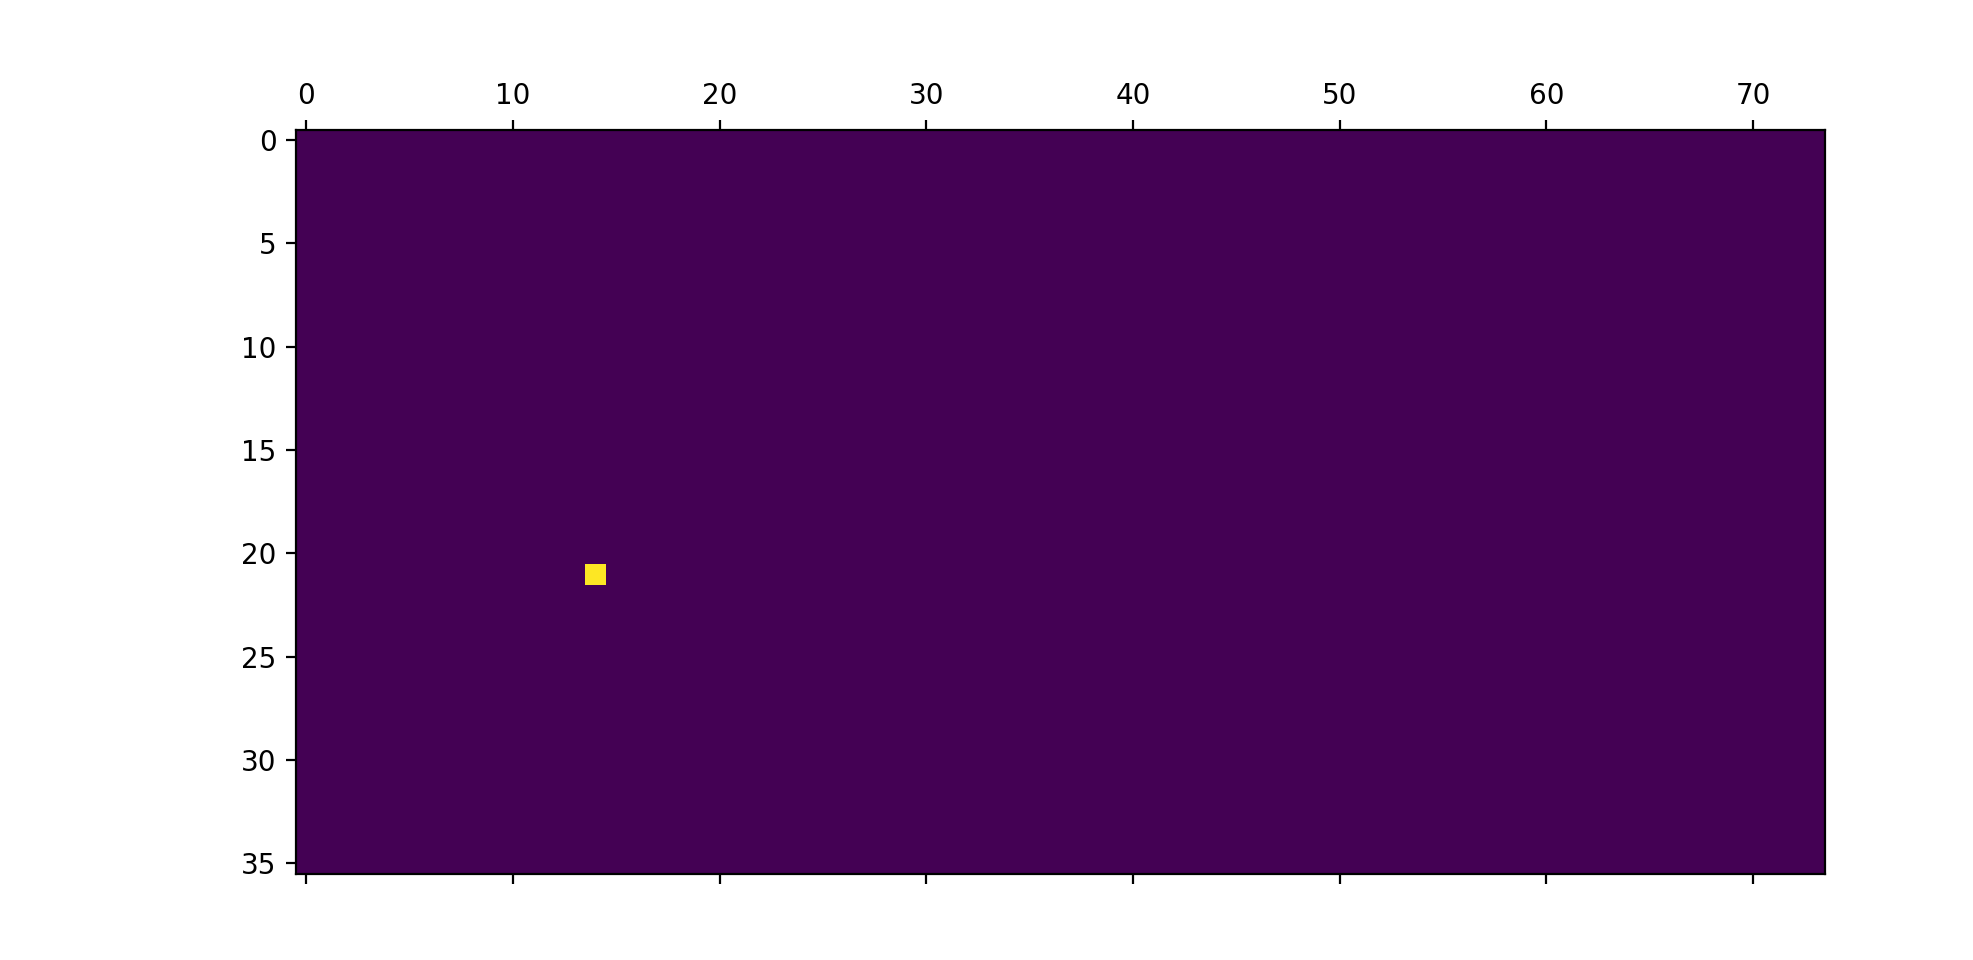

In [18]:
plt.matshow(r[1][2])

iterations = 39
[[ 0.87731798 -1.52076029]]
iterations = 573
[[-0.21237828  0.03955846]]


<IPython.core.display.Javascript object>


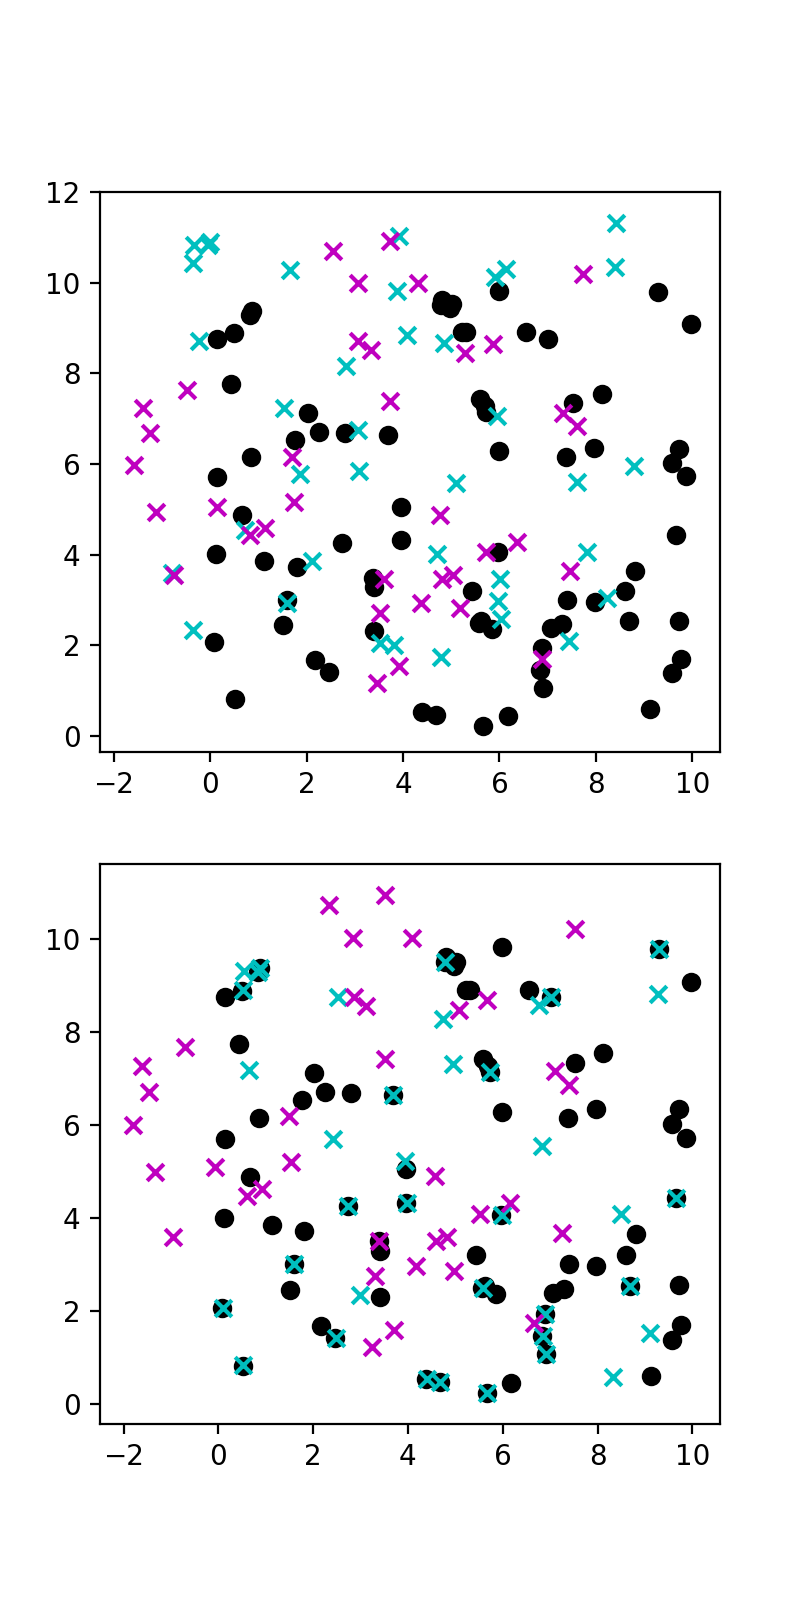

In [19]:
with np.errstate(invalid="ignore"):
    r = main2(ps1[1:], [slab[1:] for slab in slabs_wnoise], translation_registration, w=0.9, maxIterations=1000, tolerance=1e-8)

<IPython.core.display.Javascript object>


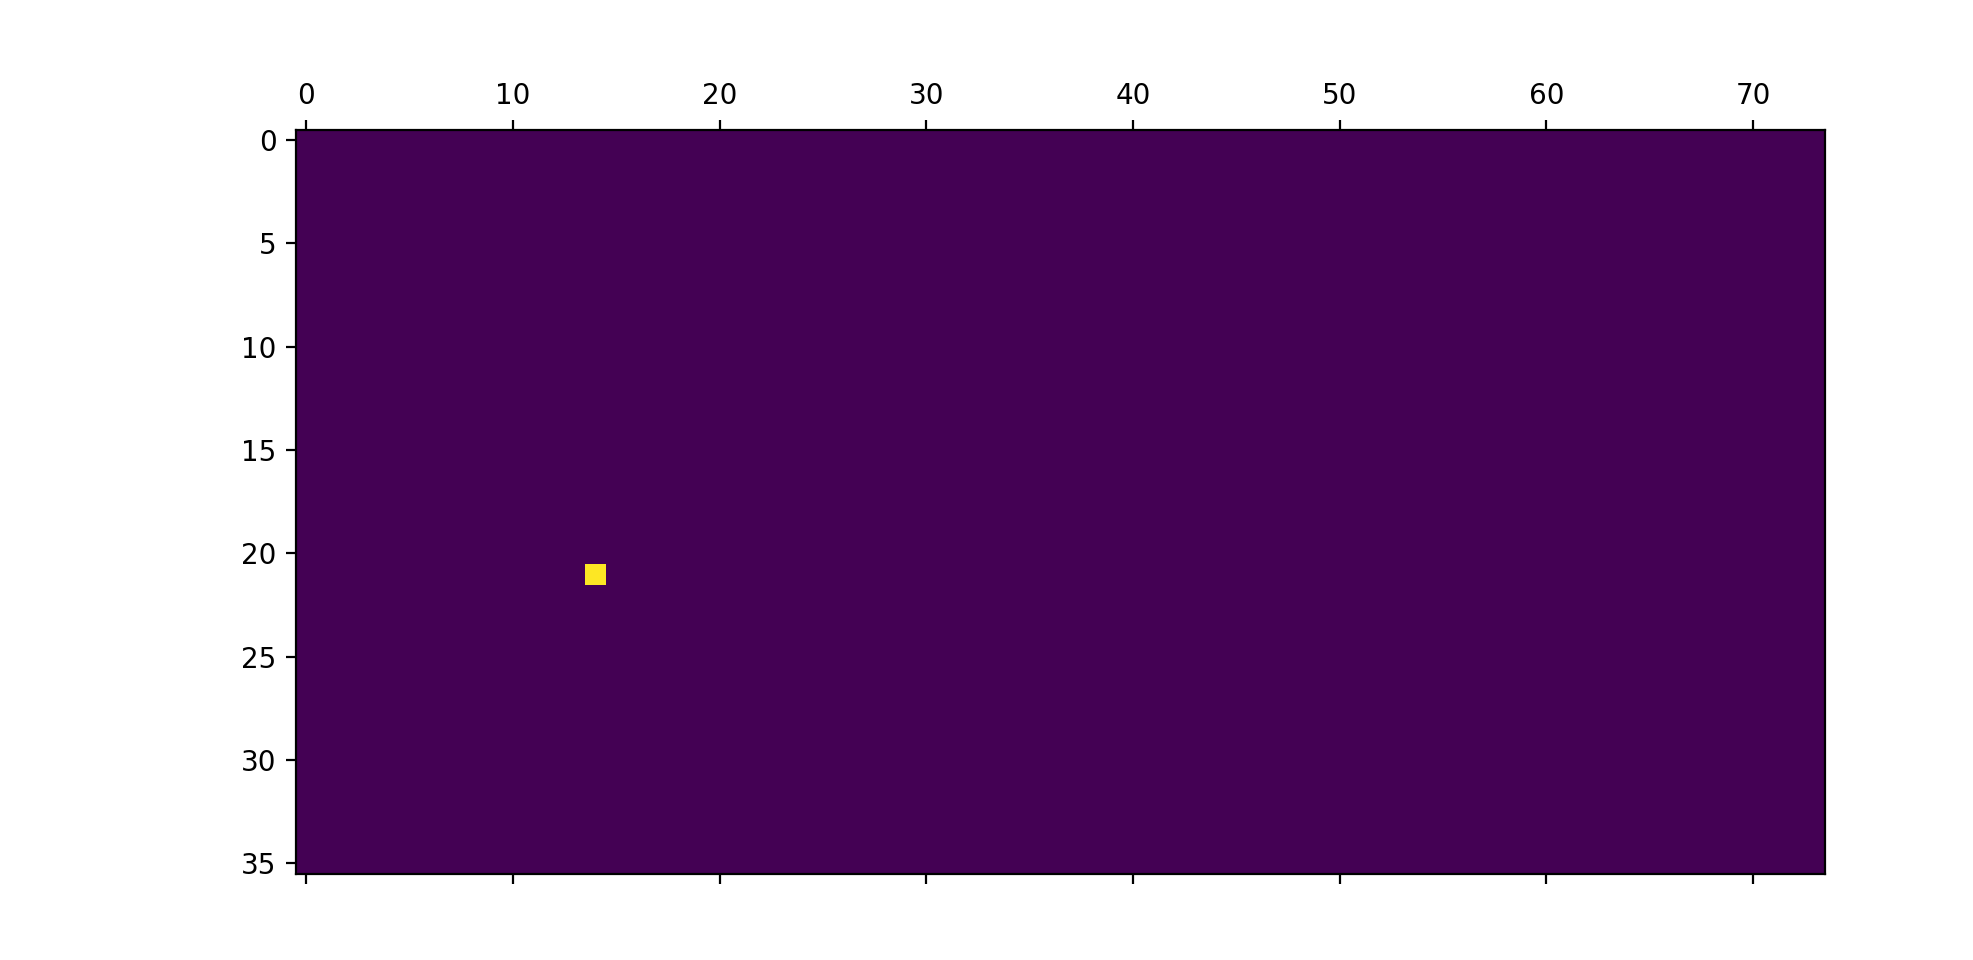

In [20]:
plt.matshow(r[1][2])

In [21]:
r[1][2].shape

(36, 74)

In [22]:
r[1][2].sum()

1.8268336744804421e-10

In [23]:
slabs_wnoise[0][1:].T.mean(axis=0)

array([ 3.88752208,  6.46489886])